# XGBoost Classification Model

> you must run the data-science.ipynb first in order to get the experimental model

# Import packages

In [9]:
# load data
# Add directory above current directory to path
import json
import sys; sys.path.insert(0, '..')
from submodules.load_data import load_data

# data manipulation
import numpy as np
import pandas as pd

# data splitting
from sklearn.model_selection import train_test_split

# data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# model
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# k-fold cross validation
from sklearn.model_selection import cross_validate

# saving models
import joblib

# performance
# Note : Updated these as scikit-learn 1.2.0 these plots are deprecated
from sklearn.metrics import ConfusionMatrixDisplay # plot_confusion_matrix  
from sklearn.metrics import PrecisionRecallDisplay # plot_precision_recall_curve
import matplotlib.pyplot as plt

from submodules.ModelDefinition import ModelExporter,SpecElement,ModelIO


# Load the data

Load semi-colon separated data from disk

In [2]:
#data = load_data()

csv_path = "../data/raw/dataSepsis.csv"
data = pd.read_csv(csv_path, sep=";")

# Create a Test Dataset

In [3]:
X_train, X_test, y_train, y_test = \
    train_test_split(data.drop(["Age", "Unit1", "Unit2", "HospAdmTime", "ICULOS", "Gender", "Bilirubin_direct", "TroponinI", "isSepsis"], axis=1),
    data["isSepsis"], test_size=0.2,
    random_state=42, stratify=data["isSepsis"])

print(X_train.columns[0])


HR


# Transformation pipeline

In [4]:
pipeline = joblib.load("../data/transform/pipeline.pkl")

# Transform the data

In [5]:
X_train_prepared = pipeline.fit_transform(X_train)

# Load the model

In [6]:
# load the model from disk
model = joblib.load("../models/experiment/xgbc_model.pkl")

# Fine tune the Model with Randomize Search Cross Validation

https://xgboost.readthedocs.io/en/latest/parameter.html


In [ ]:
print("[INFO] setting hyperparameters...")
# general
booster = ["gbtree", "dart",]

use_label_encoder = [False]
eval_metric = ["mlogloss"]
# booster
eta = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0] # learning rate range [0, 1]
min_child_weight = [0, 1, 5, 15]# Used to control over-fitting. Higher values prevent a model from learning relations
gamma = [0, 5, 10, 20] # Makes the algorithm conservative
max_depth = [3, 4, 5, 6, 7, 8, 9, 10] # Used to control over-fitting as higher depth will allow model to learn relations very specific
subsample = [0.5, 0.7, 1] # Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
colsample_bytree = [0.5, 0.7, 1] # Denotes the fraction of columns to be randomly samples for each tree.
scale_pos_weight = [1, 2, 3] # A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence
tree_method = ["auto", "exact", "approx"]
# learning tasks
objective = ["binary:logistic", "binary:logitraw", "binary:hinge"]
eval_metric = ["mlogloss", "auc", "aucpr"]
grid = dict(eta=eta, min_child_weight=min_child_weight, gamma=gamma, max_depth=max_depth, subsample=subsample,
            colsample_bytree=colsample_bytree, scale_pos_weight=scale_pos_weight, tree_method=tree_method,
            objective=objective, eval_metric=eval_metric)

[INFO] setting hyperparameters...


In [ ]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="f1", return_train_score=True)
X_train = pipeline.fit_transform(X_train)
searchResults = randomSearch.fit(X_train_prepared, y_train)

[INFO] grid searching over the hyperparameters...


/usr/local/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[15:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:28:06] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:28:06] WARNING: /Users/runner/work/xgboost/xgb

In [ ]:
# print the best score
searchResults.best_score_

0.5901373278975172

In [ ]:
# print the best combination of parameters
searchResults.best_params_

{'tree_method': 'approx',
 'subsample': 0.7,
 'scale_pos_weight': 3,
 'objective': 'binary:logitraw',
 'min_child_weight': 0,
 'max_depth': 6,
 'gamma': 5,
 'eval_metric': 'auc',
 'eta': 0.5,
 'colsample_bytree': 1}

In [ ]:
# print the best estimator directly
searchResults.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.5,
              eval_metric='auc', feature_types=None, gamma=5, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=0, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logitraw', ...)

XGBC Confusion Matrix
[[26661   262]
 [  262  1856]]


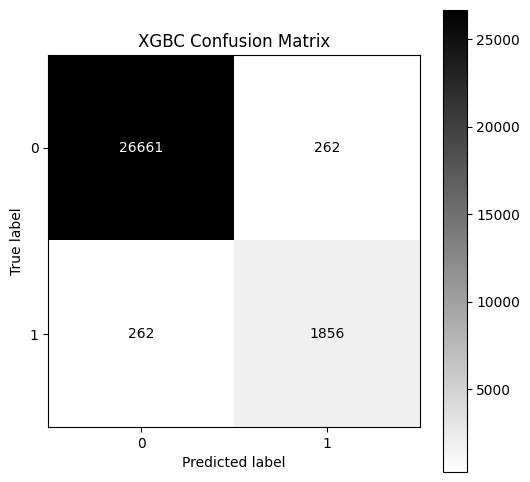

In [ ]:
# confusion matrix with best_estimator_
title = "XGBC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_estimator(searchResults.best_estimator_, X_train_prepared, y_train, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/tune/xgbc_cm.png")

# Serialize the Model

In [ ]:
# serialize the model
joblib.dump(searchResults.best_estimator_, "../models/tune/xgbc_model.pkl", compress=('bz2', 3))

['../models/tune/xgbc_model.pkl']

# Load the model

In [ ]:
# load the model from disk
model = joblib.load("../models/tune/xgbc_model.pkl")

# Test the Model

In [ ]:
X_test_prepared = pipeline.transform(X_test)

#### Confusion Matrix

XGBC Confusion Matrix
[[6574  158]
 [ 252  277]]


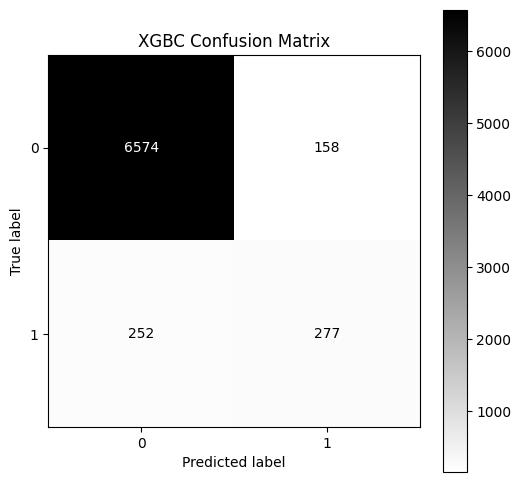

In [ ]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
# https://matplotlib.org/stable/tutorials/colors/colormaps.html

title = "XGBC Confusion Matrix"
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay.from_estimator(model, X_test_prepared, y_test, cmap="binary", ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.confusion_matrix)
plt.savefig("../reports/figures/final/xgbc_cm.png")

#### Precision Recall Curve

XGBC Precision Recall Curve
0.5969987833978602


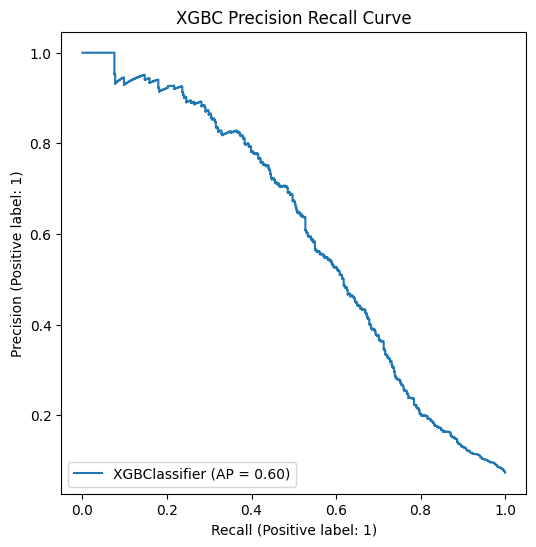

In [ ]:
# computes a precision-recall curve from the ground truth label and a score given
# by the classifier by varying a decision threshold
title = "XGBC Precision Recall Curve"
fig, ax = plt.subplots(figsize=(6, 6))
disp = PrecisionRecallDisplay.from_estimator(model, X_test_prepared, y_test, ax=ax)
disp.ax_.set_title(title)
print(title)
print(disp.average_precision)
#disp.ax_.set_title('Precision-Recall curve')
plt.savefig("../reports/figures/final/xgbc_prc.png")

In [ ]:
# serialize the model
joblib.dump(model, "../models/final/xgbc_model.pkl", compress=('bz2', 3))

['../models/final/xgbc_model.pkl']

### Export Models with Spec

In [8]:
spec = ModelIO()
# Append Inputs Required for Spec
for column in X_train.columns:
    element = SpecElement(column,"Float",True,False)
    spec.addInputElement(element)
# Add Output Spec    
spec.addOutputElement(SpecElement("isSepsis","Boolean",True,False))
modelexport = ModelExporter(model,spec)

#Export Model with Specs as Pickle File
joblib.dump(modelexport, "../models/final/xgbc_model_with_metadata.pkl", compress=('bz2', 3))



['../models/final/xgbc_model_with_metadata.pkl']

### Load and test the models with spec

In [11]:
# load the model from disk
modelexport = joblib.load("../models/final/xgbc_model_with_metadata.pkl")
loadedSpec = modelexport.spec
loadedmodel = modelexport.model
specData = json.dumps(loadedSpec.__dict__)
print(specData)



TypeError: Object of type ModelIO is not JSON serializable